In [2]:
import pandas as pd
import numpy as np
import pickle
import pydotplus
import collections
from IPython.display import Image
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

In [4]:
# setting the file name
print("Loading the data...")
# file_dir = "D:\\...\\Data\\"
df = pd.read_csv(r"/Users/sathwikmadhusudan/Desktop/Network Traffic Classification/Dataset/processed_data.csv")
print(df['class'].value_counts())
df = shuffle(df)
df['class'].value_counts()
print(f"Data loaded")

Loading the data...
class
critical       34974
transaction    25946
default        19773
OAM             2106
p2p             1619
control          993
video            379
signaling        113
bulk             111
VoIP              67
Name: count, dtype: int64
Data loaded


In [5]:

# Assume df is your DataFrame
x_names = ['protocol', 'src_port', 'dst_port', 'src2dst_packets', 'src2dst_bytes', 'dst2src_packets', 'dst2src_bytes']
y_name = ['class']

# processing input data
X = df[x_names]
X = np.asarray(X)

# processing output data
Y = df[y_name].values.ravel()  # Ensure Y is a 1d array
le = preprocessing.LabelEncoder().fit(Y)
Y = le.transform(Y)

# for debugging
print(np.shape(X), np.shape(Y))

# Splitting the dataset
x_train, x1_test, y_train, y1_test = train_test_split(X, Y, test_size=0.33, shuffle=True, random_state=42)

# applying SMOTE
smote = SMOTE(random_state=42)
X_sm, Y_sm = smote.fit_resample(X, Y)
print(np.shape(X_sm), np.shape(Y_sm))

# saving output data
dic = {}
for i in Y_sm:
    if i in dic.keys():
        dic[i] += 1
    else:
        dic[i] = 1
print(dic)


(86081, 7) (86081,)
(349740, 7) (349740,)
{5: 34974, 6: 34974, 4: 34974, 8: 34974, 0: 34974, 3: 34974, 9: 34974, 1: 34974, 7: 34974, 2: 34974}


In [6]:
# feature selection(use if necessary)
"""
SelectKBest(mutual_info_classif, k=3)
k=7 all
k=5 dst_port, src_dst_bytes, dst_src_bytes, protocol, src_des_packets
k=3 dst_port, src_dst_bytes, dst_src_bytes

SelectKBest(score_func=chi2, k=5)
k=7 all
k=5 dst_port, src_dst_bytes, dst_src_bytes, src_port, des_port
k=3 dst_port, src_dst_bytes, dst_src_bytes

"""
#X_new = SelectKBest(mutual_info_classif, k=5).fit_transform(X_sm, Y_sm)

# data splitting
print("Splitting the data")
x_train, x_test, y_train, y_test = train_test_split(X_sm, Y_sm, test_size=0.30, shuffle=True)
print("Data splitting done!")

Splitting the data
Data splitting done!


In [7]:
# Training with Random Forest
print("Starting to train Random Forest classifier")
rf = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42)
rf.fit(x_train, y_train)
print(f"Classifier description\n{rf}")
print("Testing the classifier")

y_pred = rf.predict(x1_test)
print('Accuracy %s' % accuracy_score(y1_test, y_pred))
print("Classes: ", le.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
print(classification_report(y1_test, y_pred, target_names=le.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), labels=range(10)))

# Saving the model
print("Saving the model")
filename = "random_forest_model.sav"
pickle.dump(rf, open(filename, 'wb'))
print("Saved the model")


Starting to train Random Forest classifier
Classifier description
RandomForestClassifier(max_depth=8, random_state=42)
Testing the classifier
Accuracy 0.9148801351779491
Classes:  ['OAM' 'VoIP' 'bulk' 'control' 'critical' 'default' 'p2p' 'signaling'
 'transaction' 'video']
              precision    recall  f1-score   support

         OAM       0.96      0.99      0.98       709
        VoIP       0.04      1.00      0.08        21
        bulk       0.07      0.92      0.13        36
     control       1.00      0.99      0.99       306
    critical       1.00      0.96      0.98     11500
     default       0.99      0.81      0.89      6563
         p2p       0.57      0.94      0.71       539
   signaling       0.05      0.92      0.10        38
 transaction       0.98      0.93      0.96      8579
       video       0.27      0.78      0.40       116

    accuracy                           0.91     28407
   macro avg       0.59      0.92      0.62     28407
weighted avg       0.9

In [8]:
# Confusion matrix graph
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[  701     0     3     0     0     1     0     1     3     0]
 [    0    21     0     0     0     0     0     0     0     0]
 [    0     0    33     0     0     1     2     0     0     0]
 [    0     0     1   303     2     0     0     0     0     0]
 [    0    27     0     0 11010    15     0   442     5     1]
 [    5   473   277     1     0  5288   279   170    70     0]
 [    2     1     1     0     0     4   505     4    22     0]
 [    0     3     0     0     0     0     0    35     0     0]
 [   20     1   160     0     0    53    95     4  8002   244]
 [    0     0     0     0     0     1     0     0    24    91]]
Normalized confusion matrix


/var/folders/8w/96rv308138b_1rxr1ndf_2880000gn/T/ipykernel_33305/1737189056.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


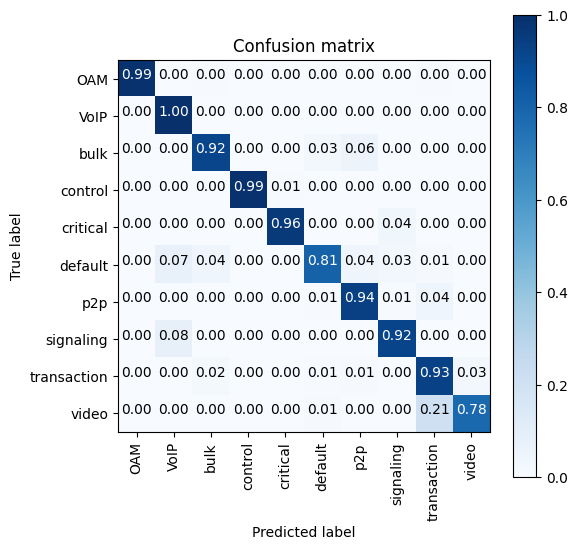

In [9]:
# Confusion matrix
fig = plt.figure()
fig.set_size_inches(6, 6, forward=True)
fig.align_labels()

cm = confusion_matrix(y1_test, y_pred)
print(cm)
plot_confusion_matrix(cm, normalize=True, title='Confusion matrix', classes=le.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
fig.show()
fig.savefig(str('7') + "_cm_rf.png")